# Empirical Finance
## Exercise 2 (Question 1): Out-of-sample $R^2$

We compare two forecasting models for US monthly stock returns:

**Benchmark model**
$$
y_t = \alpha + \varepsilon_t
$$
This implies the OOS forecast is just the historical mean return estimated in the rolling window.

**Competing model**
$$
y_t = \alpha + \beta x_{t-1} + \varepsilon_t
$$
where $x_{t-1}$ is the lagged term spread (US 10Y − US 3M).

**Goal (Q1):** Using a **10-year rolling window (120 months)**, generate OOS forecasts for both models and compute:
$$
R^2_{oos} = 1 - \frac{\sum (y_t - \hat y^{comp}_t)^2}{\sum (y_t - \hat y^{bench}_t)^2}
$$
If $R^2_{oos} > 0$, the competing model improves forecasting accuracy relative to the benchmark (in terms of MSE).

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

We load the Excel filea and convert the `Date` column to datetime and set it as the index.

In [2]:
file_path = "Assignemnt1_EF_data.xlsx"
df = pd.read_excel(file_path)

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.set_index("Date").sort_index()

df.head()

,US 10 Year,UK 10 Year,US 3 month,UK 3 month,US Stock Market,UK Stock Market,USDperGBP
Date,,,,,,,
1956-01-31,2.90,4.55,2.32,4.07,13.001249,6.8667,2.8064
1956-02-29,2.84,4.61,2.30,4.67,13.492372,6.5458,2.8088
1956-03-31,2.96,4.68,2.30,5.18,14.472296,6.5519,2.8048
1956-04-30,3.18,4.59,2.69,5.11,14.486981,7.1767,2.8059
1956-05-31,3.07,4.77,2.57,4.95,13.577881,6.9279,2.8025


## Build $y_t$ and $x_{t-1}$

- $y_t$ is the monthly US stock return between $t-1$ and $t$.  
  I use **log returns**:
  $$
  y_t = \log(P_t / P_{t-1})
  $$
  This is standard and it makes compounding easier.

- Term spread at time \(t\):
  $$
  x_t = (US\ 10Y_t - US\ 3M_t)
  $$
- Predictor is **lagged spread** $x_{t-1}$, so we shift by one month to avoid look-ahead bias.

In [3]:
# monthly log return
df["y"] = np.log(df["US Stock Market"] / df["US Stock Market"].shift(1))

# term spread (in percentage points)
df["x"] = df["US 10 Year"] - df["US 3 month"]

# lagged term spread
df["x_lag"] = df["x"].shift(1)

data = df[["y", "x_lag"]].dropna()

data.head()

,y,x_lag
Date,,
1956-02-29,0.037079,0.58
1956-03-31,0.070112,0.54
1956-04-30,0.001014,0.66
1956-05-31,-0.064808,0.49
1956-06-30,0.041721,0.50


## Rolling window OOS forecasts (10 years = 120 months)

For each month $t$ after the first 120 observations:

- **Benchmark** forecast:
  $$
  \hat y^{bench}_t = \bar{y} \ \text{(mean of y in the rolling window)}
  $$

- **Competing** forecast:
  Fit OLS on the rolling window:
  $$
  y = \alpha + \beta x_{t-1} + \varepsilon
  $$
  and then predict $\hat y^{comp}_t$ at time $t$.

This is the standard "fit -> forecast -> move window by one month" procedure we discussed in class.

In [4]:
W = 120  # 10 years * 12 months

y = data["y"].values
xlag = data["x_lag"].values
dates = data.index

# store forecasts
f_bench = np.full(len(data), np.nan)
f_comp = np.full(len(data), np.nan)

for t in range(W, len(data)):
    y_train = y[t-W:t]
    x_train = xlag[t-W:t]

    # benchmark = historical mean in the window
    f_bench[t] = np.mean(y_train)

    # competing = OLS on (y_train, x_train)
    X_train = sm.add_constant(x_train)  # adds intercept
    model = sm.OLS(y_train, X_train).fit()

    # forecast for month t using xlag[t]
    X_t = np.array([1.0, xlag[t]])
    f_comp[t] = X_t @ model.params

# keep only OOS period
oos = ~np.isnan(f_bench)

y_oos = y[oos]
fb_oos = f_bench[oos]
fc_oos = f_comp[oos]
dates_oos = dates[oos]

(len(y_oos), dates_oos[0], dates_oos[-1])

(720, Timestamp('1966-02-28 00:00:00'), Timestamp('2026-01-31 00:00:00'))

## Compute $R^2_{oos}$

We compute the OOS sum of squared forecast errors for both models:

$$
SSE_{bench} = \sum (y_t - \hat y^{bench}_t)^2,\quad
SSE_{comp}  = \sum (y_t - \hat y^{comp}_t)^2
$$

Then:

$$
R^2_{oos} = 1 - \frac{SSE_{comp}}{SSE_{bench}}
$$

Interpretation:
- $R^2_{oos} > 0$: competing model improve OOS accuracy vs benchmark.
- $R^2_{oos} < 0$: competing model is worse than the benchmark mean forecast.

In [5]:
sse_bench = np.sum((y_oos - fb_oos)**2)
sse_comp = np.sum((y_oos - fc_oos)**2)

R2_oos = 1 - (sse_comp / sse_bench)

print("SSE benchmark:", sse_bench)
print("SSE competing :", sse_comp)
print("R2_oos        :", R2_oos)

SSE benchmark: 1.389726651671191
SSE competing : 1.3963143413604524
R2_oos        : -0.00474027729218518


## Quick sanity check to compare

We compare the average squared forecast errors (MSE-like).  
This should be consistent with the sign of $R^2_{oos}$.

Mean squared error (bench): 0.0019301759050988764
Mean squared error (comp) : 0.0019393254741117394


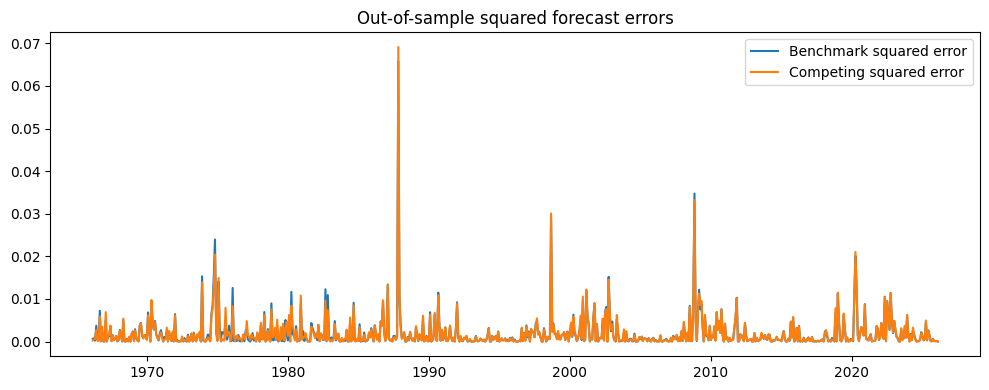

In [6]:
# Ensure dates are datetime (important for slicing and plotting)
dates_oos_dt = pd.to_datetime(dates_oos)

# Squared forecast errors (losses)
loss_b = (y_oos - fb_oos) ** 2
loss_c = (y_oos - fc_oos) ** 2

print("Mean squared error (bench):", float(np.mean(loss_b)))
print("Mean squared error (comp) :", float(np.mean(loss_c)))

plt.figure(figsize=(10, 4))
plt.plot(dates_oos_dt, loss_b, label="Benchmark squared error")
plt.plot(dates_oos_dt, loss_c, label="Competing squared error")
plt.title("Out-of-sample squared forecast errors")
plt.legend()
plt.tight_layout()
plt.show()

This raw plot confirms that monthly squared errors are highly volatile and often overlap.
To compare performance in a more interpretable way, we next look at smoothed losses and the cumulative loss differential.

### OOS loss dynamics: rolling MSPE and cumulative gains

Monthly losses are heteroskedastic and can be dominated by a handful of extreme observations.
To make model comparisons clearer, we will focus on two complementary diagnostics:

1. A 12-month rolling mean of squared errors (rolling MSPE), which smooths short-run noise.
2. The cumulative loss differential:
$$
\sum_{t \le T} \left(\ell^b_t - \ell^c_t\right),
\qquad
\ell^j_t = (y_t - \hat y^j_t)^2,\; j\in\{b,c\}.
$$

An upward-sloping cumulative curve indicates persistent gains from the competing model whereas a downward trend indicates that the benchmark dominates.

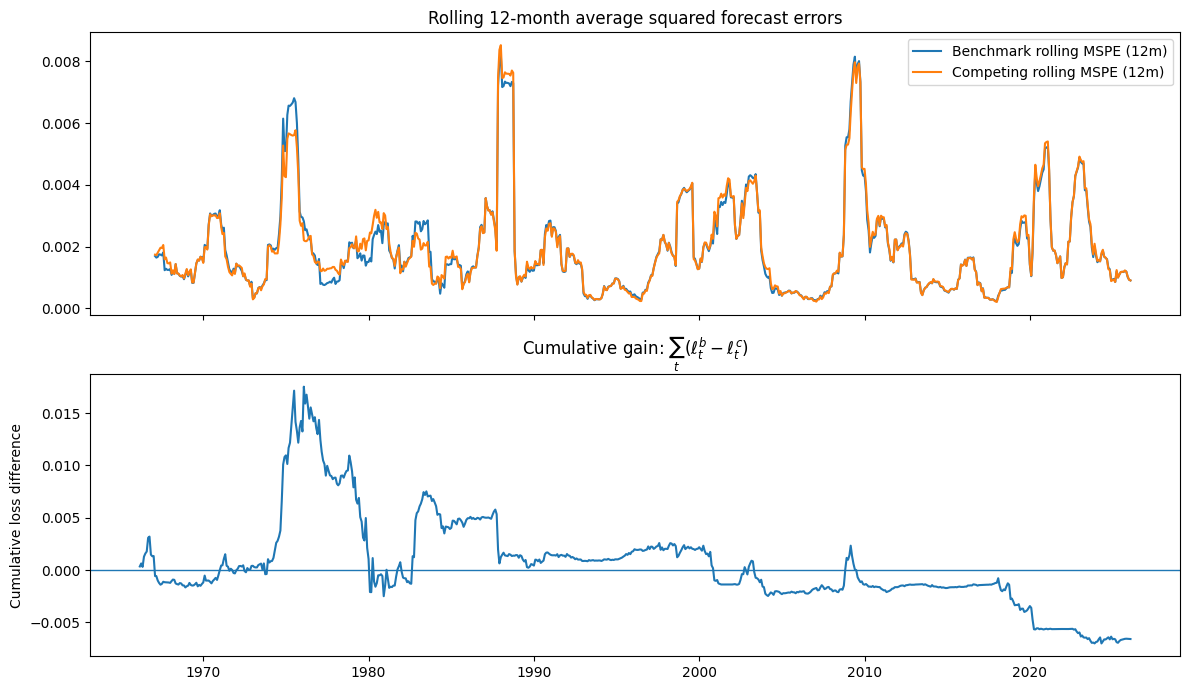

In [7]:
roll = 12

loss_b_s = pd.Series(loss_b, index=dates_oos_dt)
loss_c_s = pd.Series(loss_c, index=dates_oos_dt)

roll_b = loss_b_s.rolling(roll).mean()
roll_c = loss_c_s.rolling(roll).mean()

cum_gain = (loss_b_s - loss_c_s).cumsum()

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax[0].plot(roll_b.index, roll_b.values, label=f"Benchmark rolling MSPE ({roll}m)")
ax[0].plot(roll_c.index, roll_c.values, label=f"Competing rolling MSPE ({roll}m)")
ax[0].set_title(f"Rolling {roll}-month average squared forecast errors")
ax[0].legend()

ax[1].plot(cum_gain.index, cum_gain.values)
ax[1].axhline(0, linewidth=1)
ax[1].set_title(r"Cumulative gain: $\sum_t (\ell^b_t - \ell^c_t)$")
ax[1].set_ylabel("Cumulative loss difference")

plt.tight_layout()
plt.show()

In our sample, the rolling MSPE series are very close most of the time. The cumulative gain curve doesn't display a sustained upward drift; instead it suggests that any relative advantage of the competing model is episodic and often offset later in the sample.

### Out-of-sample performance summary

We summarize overall forecast performance using the OOS $R^2$:
$$
R^2_{\text{oos}} = 1 - \frac{\text{MSPE}_c}{\text{MSPE}_b},
\qquad
\text{MSPE}_j = \frac{1}{T}\sum_{t=1}^{T} (y_t-\hat y^j_t)^2,\; j\in\{b,c\}.
$$

A negative $R^2_{\text{oos}}$ means the competing model underperforms the historical-mean benchmark
in MSPE terms.

In [8]:
mspe_b = float(loss_b_s.mean())
mspe_c = float(loss_c_s.mean())
r2_oos = 1.0 - mspe_c / mspe_b

summary = pd.DataFrame({
    "Metric": ["MSPE_benchmark", "MSPE_competing", "R2_oos"],
    "Value":  [mspe_b, mspe_c, r2_oos]
})

display(summary)

,Metric,Value
0,MSPE_benchmark,0.001930
1,MSPE_competing,0.001939
2,R2_oos,-0.004740


Consistent with the loss diagnostics, the OOS $R^2$ is slightly negative (about $-0.0047$ in our run), meaning the term-spread model does not beat the historical-mean benchmark on average in this OOS design.

To assess whether this MSPE difference is statistically meaningful (rather than sampling noise), we next apply the Clark–West (2007) test for nested forecast comparisons.

### Subsample evidence across economic regimes (optional)

Predictability can vary across monetary and financial regimes. As a complement to the full-sample $R^2_{\text{oos}}$, we compute MSPEs and $R^2_{\text{oos}}$ by subperiods. This is mainly descriptive: it helps check whether any predictability is episodic rather than stable.

In [9]:
periods = [
    ("1965-01-01", "1984-12-31", "Pre-Volcker / high inflation"),
    ("1985-01-01", "2006-12-31", "Great Moderation"),
    ("2007-01-01", "2013-12-31", "GFC + aftermath"),
    ("2014-01-01", "2019-12-31", "Low vol / expansion"),
    ("2020-01-01", "2025-12-31", "Covid + inflation shock"),
]

rows = []
for s, e, label in periods:
    lb_slice = loss_b_s.loc[s:e]
    lc_slice = loss_c_s.loc[s:e]

    # Skip empty slices safely (in case dates don't cover a period)
    if len(lb_slice) == 0:
        continue

    rows.append({
        "period": label,
        "start": s,
        "end": e,
        "T_oos": int(lb_slice.shape[0]),
        "MSPE_b": float(lb_slice.mean()),
        "MSPE_c": float(lc_slice.mean()),
        "R2_oos": float(1.0 - lc_slice.mean() / lb_slice.mean())
    })

subsample_table = pd.DataFrame(rows)
display(subsample_table)

,period,start,end,T_oos,MSPE_b,MSPE_c,R2_oos
0,Pre-Volcker / high inflation,1965-01-01,1984-12-31,227,0.001882,0.001864,0.009427
1,Great Moderation,1985-01-01,2006-12-31,264,0.001901,0.001923,-0.011535
2,GFC + aftermath,2007-01-01,2013-12-31,84,0.002459,0.002457,0.000855
3,Low vol / expansion,2014-01-01,2019-12-31,72,0.001081,0.001107,-0.023851
4,Covid + inflation shock,2020-01-01,2025-12-31,72,0.002446,0.002489,-0.017859


The subsample results suggest that any gains from the term spread are not stable over time:
indeed some periods show small improvements but others show clear underperformance, which explains why the full-sample $R^2_{\text{oos}}$ ends up close to zero and slightly negative.

## Exercise 2 - Question 2: Clark–West test (equal predictive ability)

Even if the out-of-sample $R^2$ is slightly negative, we still want to know whether the difference
in forecasting performance is statistically meaningful.

Because the competing model is **nested** in the benchmark (it reduces to the benchmark when $\beta = 0$), a standard Diebold–Mariano test is not ideal. Clark & West (2007) propose an adjusted test for nested models.

**Step 1 (build the CW adjustment series):**

Let: $$\hat e_{t,BEN} = y_t - \hat y_{t,BEN}$$ and $$\hat e_{t,MOD} = y_t - \hat y_{t,MOD}$$

Then define:

$$
f_t = \hat e_{t,BEN}^2 - \left[\hat e_{t,MOD}^2 - (\hat y_{t,BEN} - \hat y_{t,MOD})^2 \right]
$$

**Step 2 (regress on a constant):**
$$
f_t = \rho + \eta_t
$$

**Step 3 (one-sided t-test):**
$$
H_0: \rho \le 0 \quad\text{vs}\quad H_A: \rho > 0
$$
The Clark–West statistic is just the t-stat on the intercept $\rho$.

In [10]:
# Forecast errors
e_b = y_oos - fb_oos
e_c = y_oos - fc_oos

# Clark–West f_t series (following the tutorial formula)
f_t = (e_b**2) - ( (e_c**2) - (fb_oos - fc_oos)**2 )

# Regress f_t on a constant
X = np.ones(len(f_t))
cw_reg = sm.OLS(f_t, X).fit()

rho_hat = cw_reg.params[0]
se_rho  = cw_reg.bse[0]
CW_stat = rho_hat / se_rho

print("rho_hat =", rho_hat)
print("se(rho) =", se_rho)
print("Clark-West statistic (t-stat) =", CW_stat)

rho_hat = 3.428119098020368e-05
se(rho) = 2.1851583048885713e-05
Clark-West statistic (t-stat) = 1.5688195634847517


The Clark–West test delivers a positive but borderline statistic (1.57). Although this suggests that the term spread model may contain some predictive information, the null hypothesis of equal predictive ability cannot be rejected at conventional significance levels.

### Interpreting the Clark–West statistic

This is a **one-sided** test. The idea is simple: if the term spread model genuinely improves forecasts, the adjusted mean of $f_t$ should be positive, so the CW t-stat should be “large” and positive.

As a rough benchmark, a 5% one-sided critical value is around **1.65**. In our case the CW statistic is positive but below that threshold, so on a standard asymptotic rule we would not reject equal predictive ability.

However, the assignment explicitly asks for a bootstrap critical value, so we compute that next.

## Exercise 2 - Question 3: Bootstrap critical value for the Clark–West statistic

The assignment asks us to **bootstrap the critical value** of the Clark–West statistic, instead of relying only on an asymptotic cutoff like 1.65.

The intuition is the following:
- We already have the Clark–West adjustment series $f_t$.
- The Clark–West statistic is basically the **t-stat** from the regression:
$$
f_t = \rho + \eta_t
$$
(i.e., regression on a constant).

And the idea of the bootstrap is the following:
- Create many pseudo-samples $f_t^{*}$ by resampling the original $f_t$.
- For each pseudo-sample, recompute the CW t-stat.
- This gives a bootstrap distribution of the CW statistic.
- Since the test is **one-sided** ($H_A:\rho > 0$), the 5% critical value is the **95th percentile** of the bootstrap distribution.

Because time-series objects can have some dependence, we use a **block bootstrap** (resample blocks of consecutive months) rather than resampling individual months.

In [11]:
# We fix the random seed so the bootstrap is reproductible 
# (same results each time we run the notebook), the number inside doesn't really matter
np.random.seed(333)

### Block bootstrap setup

Choices we need to make (and we'll state them as assumptions):

- Number of bootstrap replications $B$: we’ll use 2000 (enough to get a stable quantile).
- Block length: we’ll use 12 months (roughly one year), which is a common simple choice in monthly data.

These values are reasonable for this coursework.

In [12]:
B = 2000        # number of bootstrap draws
block_len = 12  # block length in months (one-year blocks)

T = len(f_t)
n_blocks = int(np.ceil(T / block_len))

print("T =", T, "| block_len =", block_len, "| n_blocks =", n_blocks, "| B =", B)

T = 720 | block_len = 12 | n_blocks = 60 | B = 2000


### Bootstrap loop: resample blocks and recompute the CW t-stat

For each bootstrap replication:
1) draw blocks of length `block_len` (with replacement),
2) paste them together to get a bootstrap sample $f_t^{*}$ of length $T$,
3) compute the CW t-stat from the regression of $f_t^{*}$ on a constant.

In [13]:
cw_boot = np.zeros(B)

for b in range(B):
    # build bootstrap index by sampling blocks
    idx = []

    for _ in range(n_blocks):
        start = np.random.randint(0, T - block_len + 1)
        block = list(range(start, start + block_len))
        idx.extend(block)

    # trim to length T
    idx = idx[:T]

    # bootstrap sample
    f_star = f_t[idx]

    # CW statistic = t-stat from regression f_star on a constant
    X_star = np.ones(T)
    reg_star = sm.OLS(f_star, X_star).fit()

    cw_boot[b] = reg_star.params[0] / reg_star.bse[0]

### Bootstrap critical value (one-sided)

Since $H_A$ is one-sided ($\rho > 0$), the 5% critical value is the 95th percentile of the bootstrap distribution.
Then I compare my observed CW statistic to that bootstrap cutoff.

In [14]:
crit_95 = np.quantile(cw_boot, 0.95)

print("Observed CW statistic:", CW_stat)
print("Bootstrap 95% critical value (one-sided):", crit_95)

if CW_stat > crit_95:
    print("Decision: reject H0 (evidence the competing model predicts better OOS).")
else:
    print("Decision: fail to reject H0 (no strong evidence of better OOS prediction).")

Observed CW statistic: 1.5688195634847517
Bootstrap 95% critical value (one-sided): 3.3496168024980877
Decision: fail to reject H0 (no strong evidence of better OOS prediction).


We can see the distribution.
This plot is just to see where the observed CW statistic sits relative to the bootstrap distribution.
It’s not required, but it helps to explain the result in the report.

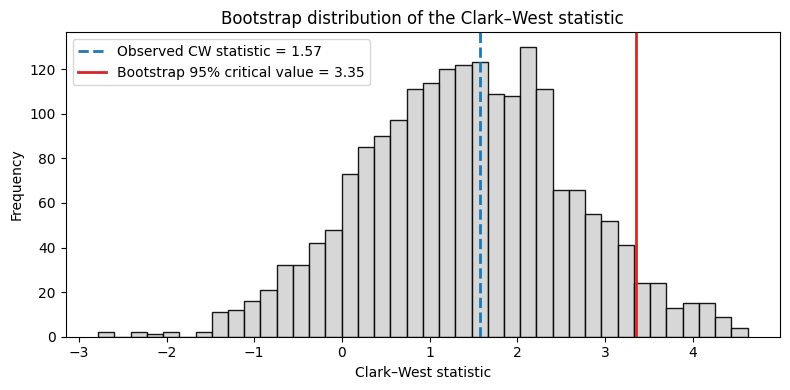

In [15]:
# Quick visual check: where does the observed CW stat lie in the bootstrap distribution?
plt.figure(figsize=(8, 4))

# Bootstrap distribution
plt.hist(cw_boot, bins=40, color="lightgray", edgecolor="black", alpha=0.9)

# Observed statistic
plt.axvline(
    CW_stat,
    color="tab:blue",
    linewidth=2,
    linestyle="--",
    label=f"Observed CW statistic = {CW_stat:.2f}"
)

# Bootstrap critical value
plt.axvline(
    crit_95,
    color="tab:red",
    linewidth=2,
    linestyle="-",
    label=f"Bootstrap 95% critical value = {crit_95:.2f}"
)

plt.title("Bootstrap distribution of the Clark–West statistic")
plt.xlabel("Clark–West statistic")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

This figure plots the bootstrap distribution of the Clark–West statistic using a 12-month block bootstrap. The first vertical line marks the observed Clark–West statistic (1.57), while the second vertical line marks the 5% one-sided bootstrap critical value (3.35).

The observed statistic lies well inside the main mass of the bootstrap distribution and clearly below the critical value. We can say that this visual evidence confirms the formal test result: we fail to reject the null hypothesis of equal predictive ability, as the term spread model doesn't deliver a statistically significant improvement in out-of-sample forecasting performance.

### Clark–West test with bootstrap critical value (final interpretation)

The observed Clark–West statistic is 1.57, but the 5% one-sided bootstrap critical value (12-month blocks, B = 2000) is about 3.25. Since 1.57 < 3.25, we fail to reject equal predictive ability, meaning the term spread model does not provide a statistically significant out-of-sample forecasting improvement over the historical-mean benchmark in this rolling-window setting.

### Exercise 2 - Question 4 (Discussion of results)

In this exercise we check whether the US term spread can actually help forecast monthly US stock returns out-of-sample. We run here a simple 10-year rolling window setup and compare a historical-mean benchmark to a model that adds the lagged term spread as a predictor.

The out-of-sample $R^2$ comes out slightly negative ($R^2_{oos} = -0.0047$). So, in plain terms, the term spread model doesn'tt beat the benchmark on average: it delivers a slightly higher mean squared forecast error. This also matches what we see in the squared forecast error plot. The two models look extremely similar most of the time, and when returns are extreme (high volatility episodes), the competing model does not seem to “save” the forecast errors relative to the benchmark.

To make this more formal, we use the Clark and West (2007) test, which is designed for nested models like this one. The Clark–West statistic is positive (1.57), so it points in the “right” direction, but it is not large enough to claim a statistically significant improvement at standard levels. Once we bootstrap the critical value using a 12-month block bootstrap, the one-sided 5% critical value is around 3.25, which is well above 1.57. So we clearly fail to reject equal predictive ability.

Overall, our takeaway is that the term spread might contain some information in-sample, but in this rolling out-of-sample framework it does not translate into a reliable forecasting edge. The historical-mean benchmark is still hard to beat, especially once we account for estimation noise and the nested-model issue.

Question 3

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

data = df.copy()

data['rf_us'] = (data['US 3 month'] / 100) / 12

data['ret_us'] = np.log(data['US Stock Market'] /
                        data['US Stock Market'].shift(1))
data['rx_us'] = data['ret_us'] - data['rf_us']

data['UK_Price_USD'] = data['UK Stock Market'] * data['USDperGBP']
data['ret_uk_usd'] = np.log(
    data['UK_Price_USD'] / data['UK_Price_USD'].shift(1))
data['rx_uk'] = data['ret_uk_usd'] - data['rf_us']

# 4. Predictors
data['spread_us'] = (data['US 10 Year'] - data['US 3 month']) / 100
data['spread_uk'] = (data['UK 10 Year'] - data['UK 3 month']) / 100

data['x_us'] = data['spread_us'].shift(1)
data['x_uk'] = data['spread_uk'].shift(1)

cols_needed = ['rx_us', 'rx_uk', 'x_us', 'x_uk', 'rf_us']
df_clean = data[cols_needed].dropna()

In [17]:
window = 120
target_vol_ann = 0.10
target_vol_m = target_vol_ann / np.sqrt(12)
gamma = 3  # Risk aversion

oos_returns_bench = []
oos_returns_comp = []
weights_bench = [] 
weights_comp = []

RX = df_clean[['rx_us', 'rx_uk']].values
X = df_clean[['x_us', 'x_uk']].values
RF = df_clean['rf_us'].values

for t in range(window, len(df_clean)):

    rx_train = RX[t-window:t]
    x_train = X[t-window:t]

    mu_bench = np.mean(rx_train, axis=0) 
    cov_bench = np.cov(rx_train.T)       

    mu_comp = np.zeros(2)
    residuals = np.zeros((window, 2))

    model_us = sm.OLS(rx_train[:, 0], sm.add_constant(x_train[:, 0])).fit()
    mu_comp[0] = model_us.predict([1, X[t, 0]])[0]
    residuals[:, 0] = model_us.resid

    model_uk = sm.OLS(rx_train[:, 1], sm.add_constant(x_train[:, 1])).fit()
    mu_comp[1] = model_uk.predict([1, X[t, 1]])[0]
    residuals[:, 1] = model_uk.resid

    cov_comp = np.cov(residuals.T) 

    def get_weights(mu_vec, cov_mat, target_v):
        """
        function used to scale weight to acheive targeted volatility
        """
        try:
            inv_cov = np.linalg.inv(cov_mat)
            w_tan = inv_cov @ mu_vec

            vol_tan = np.sqrt(w_tan.T @ cov_mat @ w_tan)

            scale = target_v / vol_tan
            w_final = w_tan * scale
            return w_final
        except:
            return np.zeros(2) 

    w_b = get_weights(mu_bench, cov_bench, target_vol_m)
    w_c = get_weights(mu_comp, cov_comp, target_vol_m)

    weights_bench.append(w_b)
    weights_comp.append(w_c)

    ret_b = RF[t] + np.dot(w_b, RX[t])
    ret_c = RF[t] + np.dot(w_c, RX[t])

    oos_returns_bench.append(ret_b)
    oos_returns_comp.append(ret_c)


r_p_bench = np.array(oos_returns_bench)
r_p_comp = np.array(oos_returns_comp)

In [29]:
def annualize_ret(r_m):
    return np.mean(r_m) * 12


def annualize_vol(r_m):
    return np.std(r_m) * np.sqrt(12)


def sharpe_ratio(r_m, rf_m):
    # Compute sharp ratio
    excess_ret = r_m - np.mean(RF[window:])
    return (np.mean(excess_ret) * 12) / (np.std(r_m) * np.sqrt(12))


def sortino_ratio(r_m, rf_m):
    excess_ret = r_m - np.mean(RF[window:])
    downside = excess_ret[excess_ret < 0]
    downside_dev = np.std(downside) * np.sqrt(12)
    return (np.mean(excess_ret) * 12) / downside_dev

# Compute res Q1
results = pd.DataFrame(index=['Benchmark', 'Competing'],
                       columns=['Mean (Ann)', 'Vol (Ann)', 'Sharpe', 'Sortino'])

for name, r_vec in zip(['Benchmark', 'Competing'], [r_p_bench, r_p_comp]):
    results.loc[name, 'Mean (Ann)'] = annualize_ret(r_vec)
    results.loc[name, 'Vol (Ann)'] = annualize_vol(r_vec)
    results.loc[name, 'Sharpe'] = sharpe_ratio(r_vec, RF[window:])
    results.loc[name, 'Sortino'] = sortino_ratio(r_vec, RF[window:])

results

,Mean (Ann),Vol (Ann),Sharpe,Sortino
Benchmark,0.066671,0.11427,0.1833,0.232089
Competing,0.081191,0.112536,0.315153,0.423353


In [20]:
# monthly 
cer_bench_m = np.mean(r_p_bench) - 0.5 * gamma * np.var(r_p_bench)
cer_comp_m = np.mean(r_p_comp) - 0.5 * gamma * np.var(r_p_comp)

#comp delta utility
delta_cer_m = cer_comp_m - cer_bench_m

# conversion in bps
# P = Delta_CER_monthly * 12 * 10000
P_fees_bps = delta_cer_m * 12 * 10000

print(f"CER Benchmark (monthly): {cer_bench_m:.6f}")
print(f"CER Competing (monthly): {cer_comp_m:.6f}")
print(f"Performance Fee (P): {P_fees_bps:.2f} bps")

CER Benchmark (monthly): 0.003924
CER Competing (monthly): 0.005183
Performance Fee (P): 151.10 bps


In [21]:
# --- Question 3 : Break-even Transaction Costs ---

# lets use simple returns to compute weights and turnover
R_simple = np.exp(RX) - 1
Rf_simple = np.exp(RF) - 1


def calculate_turnover(weights_list, returns_array, rf_array):
    """
    Calcule le turnover mensuel moyen en tenant compte de la dérive des poids.
    weights_list : list of lisst containing the weight us and uk [w_us, w_uk]
    returns_array : simple returns at each time t
    rf_array : risk free return at each t
    """
    turnovers = []

    for i in range(len(weights_list) - 1):
        w_t = weights_list[i]

        r_assets = returns_array[i]  # R_us, R_uk
        r_f = rf_array[i]

        # portfolio return
        # Rp = w_us * R_us + w_uk * R_uk + (1 - sum(w)) * Rf
        w_rf = 1 - np.sum(w_t)
        rp = np.dot(w_t, r_assets) + w_rf * r_f

        # Drifted weights before scaling
        # w_i_drifted = w_i_t * (1 + R_i) / (1 + Rp)
        w_us_drift = w_t[0] * (1 + r_assets[0]) / (1 + rp)
        w_uk_drift = w_t[1] * (1 + r_assets[1]) / (1 + rp)

        # new weigt targeted at t+1
        w_next = weights_list[i+1]

        # Turnover = sum of abs of all transactions
        trade_us = np.abs(w_next[0] - w_us_drift)
        trade_uk = np.abs(w_next[1] - w_uk_drift)

        # TO = |Trade_US| + |Trade_UK| + |Trade_Rf|
        #Here is the trick, sum of the weights equals to 1 , trade on Rf is the tradeoff
        #considering moving cash doesn't cost anything, TO becomes sum of the cost on risky assets
        monthly_to = trade_us + trade_uk
        turnovers.append(monthly_to)

    return np.mean(turnovers)

W_bench_arr = np.array(weights_bench)
W_comp_arr = np.array(weights_comp)


TO_bench = calculate_turnover(
    W_bench_arr, R_simple[window:], Rf_simple[window:])
TO_comp = calculate_turnover(
    W_comp_arr,  R_simple[window:], Rf_simple[window:])

print(f"Monthly Turnover Benchmark : {TO_bench:.4f}")
print(f"Monthly Turnover Competing : {TO_comp:.4f}")

Monthly Turnover Benchmark : 0.1267
Monthly Turnover Competing : 0.2255


In [22]:
break_even_cost = delta_cer_m / (TO_comp - TO_bench)
break_even_bps = break_even_cost * 10000

print(f"Monty Break-even Transaction Cost : {break_even_bps:.2f} bps")

Monty Break-even Transaction Cost : 127.47 bps


In [23]:
oos_dates = df_clean.index[window:] # index for graphs

# portfolio return
s_ret_bench = pd.Series(r_p_bench, index=oos_dates)
s_ret_comp = pd.Series(r_p_comp, index=oos_dates)

s_rf = pd.Series(RF[window:], index=oos_dates)

# W_comp_arr is shape (T, 2) -> col 0 = US, col 1 = UK
df_weights_comp = pd.DataFrame(W_comp_arr, index=oos_dates, columns=[
                               'Poids US', 'Poids UK'])


#Cumulative Returns
#100 initially an dsee where we end up
wealth_bench = 100 * (1 + s_ret_bench).cumprod()
wealth_comp = 100 * (1 + s_ret_comp).cumprod()

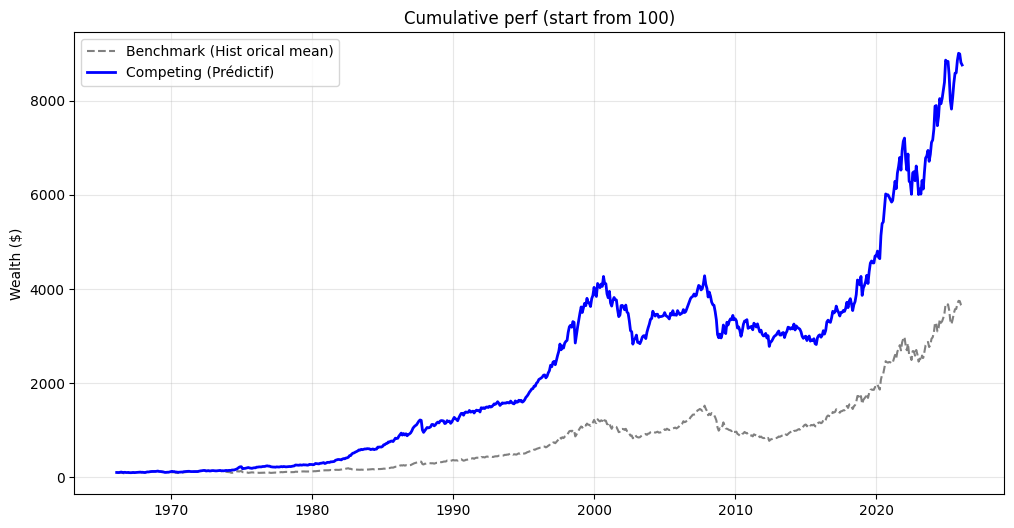

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(wealth_bench, label='Benchmark (Hist orical mean)',
         color='grey', linestyle='--')
plt.plot(wealth_comp, label='Competing (Prédictif)', color='blue', linewidth=2)
plt.title('Cumulative perf (start from 100)')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
df_weights_comp['RF'] = 1 - df_weights_comp['Poids US'] - df_weights_comp['Poids UK']

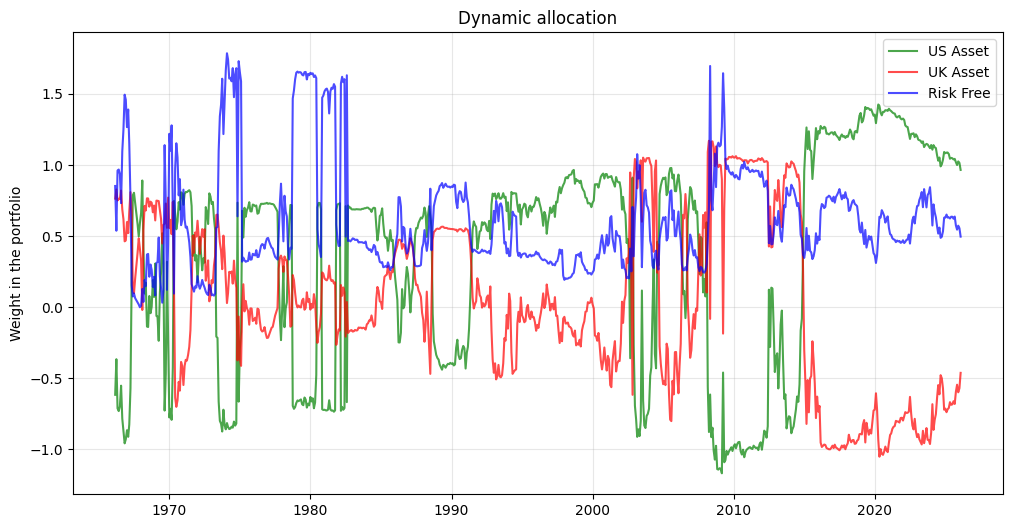

In [26]:
#Portfolio Weights
#need to add risk free 

plt.figure(figsize=(12, 6))
plt.plot(df_weights_comp['Poids US'],
         label='US Asset', color='green', alpha=0.7)
plt.plot(df_weights_comp['Poids UK'],
         label='UK Asset', color='red', alpha=0.7)
plt.plot(df_weights_comp['RF'],
         label='Risk Free', color='blue', alpha=0.7)

plt.title('Dynamic allocation')
plt.ylabel('Weight in the portfolio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
def rolling_sharpe(returns, rf, window=12):
    excess_ret = returns - rf
    roll_mean = excess_ret.rolling(window).mean() * 12
    roll_vol = returns.rolling(window).std() * np.sqrt(12)
    return roll_mean / roll_vol


roll_sr_bench = rolling_sharpe(s_ret_bench, s_rf)
roll_sr_comp = rolling_sharpe(s_ret_comp, s_rf)

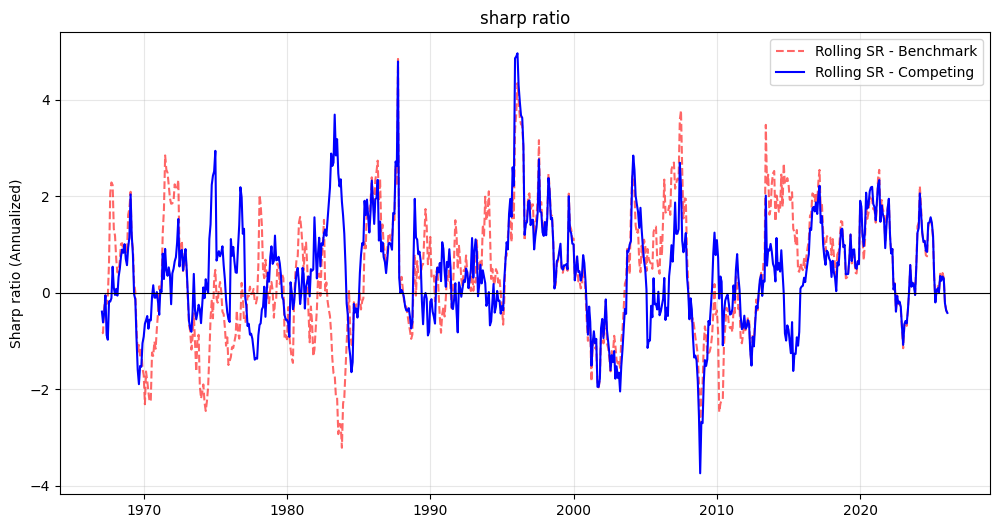

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(roll_sr_bench, label='Rolling SR - Benchmark',
         color='red', linestyle='--', alpha=0.6)
plt.plot(roll_sr_comp, label='Rolling SR - Competing',
         color='blue', linewidth=1.5)

plt.axhline(0, color='black', linewidth=0.8)  # Ligne zéro
plt.title('sharp ratio')
plt.ylabel('Sharp ratio (Annualized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()